
## Introduction
In this notebook, 


## Table of Contents



In loving memory of Donna Leung.

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import random
import shutil

import imutils
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,\
 Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, EfficientNetB0

## Functions used in this notebook:



In [ ]:
def model_eval(X_train, y_train, X_test, y_test, X_val, y_val):
  '''fn accepts above input variables and 
  returns the associated score from the most recent model'''
  train_results = model.evaluate(X_train, y_train) 
  test_results = model.evaluate(X_test, y_test)
  val_results = model.evaluate(X_val, y_val)

  return (f"Train:{train_results}, Test:{test_results}, Val:{val_results}")

In [ ]:
def save_new_images(X, y, file_path):

  '''fn reforms image files from the np.array back into a jpg'''
  i = 0
  for (img, imclass) in zip(X, y):
      if imclass == 'neg':
          cv2.imwrite(file_path + '/neg/' + str(i) + '.jpg', img)
      else:
          cv2.imwrite(file_path + '/pos/' + str(i) + '.jpg', img)
      i += 1


In [ ]:
def crop_images(images, add_pixels_value=0):
  '''fn identifies all "extreme" points of an image and crops a 
  rectangular cut based on the extreme points. Code adapted from pyimagesearch'''
  cropped = []
  # load the images, convert to greyscale and blur slightly
  for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    # thresholds image then perform a series of erosions and 
    # dilations to remove small regions of noise
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
      cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # extract extreme points
    # extLeft (West) is the X-axis min
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    # extRight (East) X-axis max
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    # extTop Y-axis max (North)
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    # extBot Y-axis min (South)
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # cropping step
    ADD_PIXELS = add_pixels_value
    new_img = image[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,\
                  extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    cropped.append(new_img)

  return np.array(cropped)

## Initial steps

1604 'No' images, 1396 'Yes' for a baseline of 46.5% yes.

In [ ]:
# The data is currerntly setup as 'yes' and 'no'. 
# I need to split this into a train, test, validation 
# with their own pos and neg:

path = '/content/drive/MyDrive/Colab/capstone/data/archive'
os.chdir(path)

In [ ]:
# THIS CODE BLOCK UNEVENLY DISTRIBUTES THE IMAGES DO NOT USE

# # get all images to a list
# yes_images = os.listdir('yes')
# no_images = os.listdir('no')

# # randomly shuffle the images around
# random.shuffle(yes_images)
# random.shuffle(no_images)

# all_images = yes_images + no_images

# # slice the images

# # setting to int to eliminate error for a partial file split
# # for this split, I'm using 70 data for training, 20% for testing
# # and 10 % for validation

# # len(all_images) # 3000 images

# train_images = all_images[:int(0.7*len(all_images))]
# test_images = all_images[int(0.7*len(all_images)): int(0.9*len(all_images))]
# val_images = all_images[int(0.9*len(all_images)):]

# len(train_images), len(test_images), len(val_images) # sanity check (2100, 600, 300)

# commenting this code out to prevent accidental reruns 
# and massive file creation
# for image in train_images:
#   if image in yes_images:
#     shutil.copy(f"yes/{image}", "train/pos")
#   else:
#     shutil.copy(f"no/{image}", "train/neg")

# for image in test_images:
#   if image in yes_images:
#     shutil.copy(f"yes/{image}", "test/pos")
#   else:
#     shutil.copy(f"no/{image}", "test/neg")

# for image in val_images:
#   if image in yes_images:
#     shutil.copy(f"yes/{image}", "val/pos")
#   else:
#     shutil.copy(f"no/{image}", "val/neg")

In [ ]:
# # DO NOT EXECUTE AGAIN
# # code block shuffles and evenly splits 'yes' and 'no' file images into 
# # train, test, val folders 'pos' and 'neg' folders
# # Each folder contains a 1:1 split of 'yes' and 'no' images
# # The original data set has more 'no' images than 'yes'. 

# yes_images = os.listdir('yes')
# no_images = os.listdir('no')

# # randomize the images
# random.shuffle(yes_images)
# random.shuffle(no_images) 

# #70% train, 20% test, 10% val
# pos_train_images = int(len(yes_images)*0.7)
# pos_test_images = int(len(yes_images)*0.2)
# pos_val_images = int(len(yes_images)*0.1)

# neg_train_images = int(len(no_images)*0.7)
# neg_test_images = int(len(no_images)*0.2)
# neg_val_images = int(len(no_images)*0.1)

# # select the images
# train_yes = yes_images[:pos_train_images]
# train_no = no_images[:neg_train_images]

# # move the files into each respective folder
# for image in train_yes:
#   shutil.move(f'yes/{image}', 'train/pos')
# for image in train_no:
#   shutil.move(f'no/{image}', 'train/neg')

# # redeclare variable with with the prior images removed
# yes_images = yes_images[pos_train_images:]
# no_images = no_images[neg_train_images:]

# # rinse and repeat for test and val

# test_yes = yes_images[:pos_test_images]
# test_no = no_images[:neg_test_images]

# for image in test_yes:
#   shutil.move(f'yes/{image}', 'test/pos')
# for image in test_no:
#   shutil.move(f'no/{image}', 'test/neg')

# yes_images = yes_images[pos_test_images:]
# no_images = no_images[neg_test_images:]

# val_yes = yes_images[:pos_val_images]
# val_no = no_images[:neg_val_images]

# for image in val_yes:
#   shutil.move(f'yes/{image}', 'val/pos')
# for image in val_no:
#   shutil.move(f'no/{image}', 'val/neg')


In [ ]:
# # This code block will move all the images back into their original folders
# # Always have an exit plan

# train_pos_images = os.listdir('train/pos')
# train_neg_images = os.listdir('train/neg')

# for image in train_pos_images:
#   shutil.move(f'train/pos/{image}', 'yes')

# for image in train_neg_images:
#   shutil.move(f'train/neg/{image}', 'no')

# test_pos_images = os.listdir('test/pos')
# test_neg_images = os.listdir('test/neg')

# for image in test_pos_images:
#   shutil.move(f'test/pos/{image}', 'yes')

# for image in test_neg_images:
#   shutil.move(f'test/neg/{image}', 'no')

# val_pos_images = os.listdir('val/pos')
# val_neg_images = os.listdir('val/neg')

# for image in val_pos_images:
#   shutil.move(f'val/pos/{image}', 'yes')

# for image in val_neg_images:
#   shutil.move(f'val/neg/{image}', 'no')


## Setup

Seed set to 33 to retain reproducibility. Parameters were chosen with the intent of comparing the base model versus a VGG16 architecture and the VGG16 pretrained model itself. 

In [5]:
datagen = ImageDataGenerator()

In [12]:
train_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/train/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

Found 2100 images belonging to 2 classes.


In [6]:
test_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/test/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

Found 600 images belonging to 2 classes.


In [7]:
val_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/val/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

Found 300 images belonging to 2 classes.


In [ ]:
X_train, y_train = train_data.next()
X_test, y_test = test_data.next()
X_val, y_val = val_data.next()

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((32, 224, 224, 3), (32,), (32, 224, 224, 3), (32,), (32, 224, 224, 3), (32,))

In [ ]:
train_data.samples, train_data.num_classes, train_data.class_indices

(2100, 2, {'neg': 0, 'pos': 1})

## Base model

To give myself a metric of how well the models are doing I am establishing a base model with no preprocessing or manipulations to the data. The base model consists of a few basic layers one might find in a basic classification model.

In [ ]:
model = Sequential()

model.add(
    Conv2D(32, kernel_size=(3, 3), 
           activation='relu', input_shape=(224, 224, 3)))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(
    Conv2D(64, kernel_size=(3, 3),
           activation='relu')
)

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics =['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    validation_data = (X_test, y_test),
                    epochs = 1000,
                    callbacks = [early_stopping],
                    verbose =0)

In [ ]:
model_eval(X_train, y_train, X_test, y_test, X_val, y_val)

'Train:[3.2253228710033e-07, 1.0], Test:[7.4761199951171875, 0.78125], Val:[13.015445709228516, 0.75]'

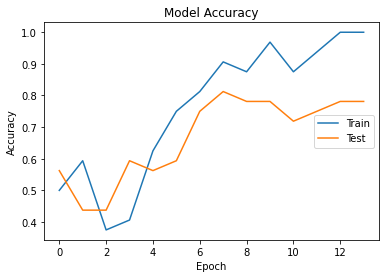

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

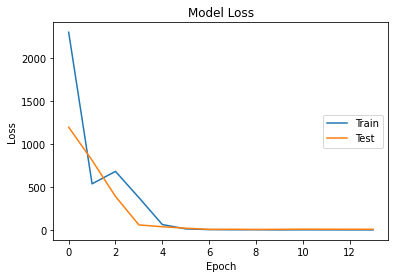

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

### Baseline results: 
Baseline accuracy 100% train, 75% on validation data. The train data is overfit and I feel the loss could be lower.

## VGG16 Architecture

[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

Based on various literature, I have decided to use VGG16 Architecture for this 
Convolutional Neural Network (CNN). VGG16 is an object detection and classification algorithm that is quite popular in this space. There are 13 convolutional layers, 5 Max Pooling layers, and 3 Dense layers adding up to 21 total layers 16 of which have weights (hence the 16). 

This model takes in a tensor size of 224, 224 and uses 3 RGB channels. But first, a baseline VGG16 style model is in order.

In [ ]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten(name='flatten'))

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics =['accuracy'])

In [ ]:
# Adjusting early stopping for a deeper dive.

es = EarlyStopping(monitor = 'val_loss', patience = 10)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    validation_data = (X_test, y_test),
                    epochs = 1000,
                    callbacks = [es],
                    verbose = 0)

In [ ]:
model_eval(X_train, y_train, X_test, y_test, X_val, y_val)

1/1 [==============================] - 0s 184ms/step - loss: 0.8063 - accuracy: 0.5000


'Train:[0.35655760765075684, 0.8125], Test:[0.5616276264190674, 0.59375], Val:[0.8062796592712402, 0.5]'

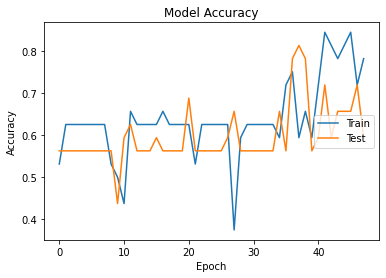

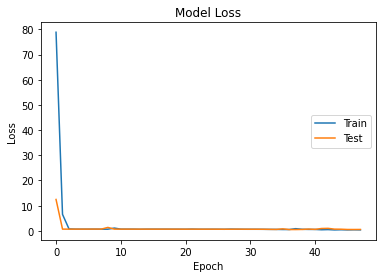

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'right')
plt.show()

Loss went down but so did accuracy. Overall a better fit model, albeit not optimal. After digging around the image files, I can see that not all the image files are the same size. There's a bunch of empty space for some of the images. 

[PyImage Search Gurus](https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

To see if the function performs as it should, I pulled the core components of the function out to test on single files. 

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Colab/capstone/data/archive/train/pos/y396.jpg')
image = cv2.resize(image, dsize = (224, 224), interpolation=cv2.INTER_CUBIC)
# INTER_CUBIC: This uses bicubic interpolation for resizing the image. 
# While resizing and interpolating new pixels, this method acts on the 4×4 
# neighboring pixels of the image. It then takes the weights average of the 
# 16 pixels to create the new interpolated pixel.
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)


thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
  cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# extract extreme points
# extLeft (West) is the X-axis min
extLeft = tuple(c[c[:, :, 0].argmin()][0])
# extRight (East) X-axis max
extRight = tuple(c[c[:, :, 0].argmax()][0])
# extTop Y-axis max (North)
extTop = tuple(c[c[:, :, 1].argmin()][0])
# extBot Y-axis min (South)
extBot = tuple(c[c[:, :, 1].argmax()][0])

# cropping step
ADD_PIXELS = 0
new_img = image[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,\
              extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

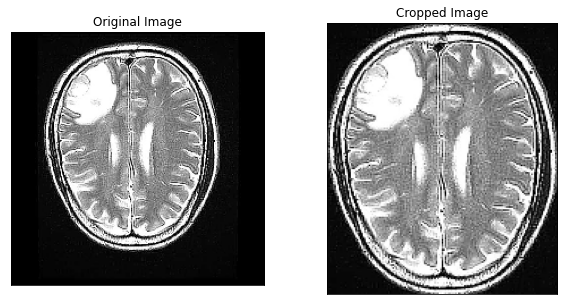

In [ ]:
fig, ax = plt.subplots(1, 2, figsize= (10,5))

ax[0].imshow(image)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Original Image')

ax[1].imshow(new_img)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Cropped Image')

plt.show()

In [ ]:
# for this function to work, I need to reimport my data as np.arrays.

labels = ['neg', 'pos']
image_size = 224
# empty lists to append the np.arrays to
X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab/capstone/data/archive/','train',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab/capstone/data/archive/','test',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab/capstone/data/archive/','val',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_val.append(img)
        y_val.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [ ]:
cropped_X_train = crop_images(images = X_train)
cropped_X_test = crop_images(images = X_test)
cropped_X_val = crop_images(images = X_val)

<ipython-input-321-bfbf791a9fa0>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(cropped)


In [ ]:
file_path = '/content/drive/MyDrive/Colab/capstone/data/archive/cropped'

In [ ]:
# # commenting out to prevent file duplication

# save_new_images(cropped_X_train, y_train, file_path + '/train')
# save_new_images(cropped_X_test, y_test, file_path + '/test')
# save_new_images(cropped_X_val, y_val, file_path+ '/val')

Importing the cropped image files for modeling into data generators. For simplicity, I've redecalred my train, test, val variables as above to run them through the model. 

In [13]:
datagen = ImageDataGenerator(rescale=1/255)

In [14]:
train_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/cropped/train/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

Found 2100 images belonging to 2 classes.


In [15]:
test_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/cropped/test/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

Found 600 images belonging to 2 classes.


In [16]:
val_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive/cropped/val/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['neg', 'pos'],
    class_mode='binary',
    batch_size= 32,
    shuffle=True,
    seed=33
)

Found 300 images belonging to 2 classes.


In [ ]:
# This architecture is a manual implementation of 
# what I understood as the foundation of VGG16
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten(name='flatten'))

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics =['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    validation_data = (X_test, y_test),
                    epochs = 1000,
                    callbacks = [es],
                    verbose =0)

In [ ]:
model_eval(X_train, y_train, X_test, y_test, X_val, y_val)

1/1 [==============================] - 0s 163ms/step - loss: 0.8673 - accuracy: 0.3125


'Train:[0.661562979221344, 0.625], Test:[0.7093635201454163, 0.5625], Val:[0.8672688007354736, 0.3125]'

I could spend months tinkering with the settings in this model but in the interest of time and resources, I'll move on to transfer learning to build upon pretrained models. I'll call upon the VGG16 pre-trained model and see how it performs. Afterwards, I'll address some hyperparameter tuning if needed.

## Utilizing transfer learning
Using VGG16 and adjusting the last couple layers for my purposes here.

In [10]:
# Import VGG16
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# freezing the base layers as to not overwrite
for layer in vgg.layers:
    layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(vgg)
# Adding a final layer like one we'd find in the model.
# The original model uses maxpooling 2D, trying average instead.
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics =['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
history = model.fit(train_data,
                    batch_size = 8,
                    validation_data = test_data,
                    epochs = 50,
                    callbacks = [es],
                    verbose = 0)

In [ ]:
accuracy_dict= {'optimizer': [], 'test_accuracy': [], 'val_accuracy': []}

In [ ]:
# model.evaluate(train_data), model.evaluate(test_data), model.evaluate(val_data)
accuracy_dict['optimizer'].append('Adam')
accuracy_dict['test_accuracy'].append(history.history['val_accuracy'][-1])
accuracy_dict['val_accuracy'].append(model.evaluate(val_data)[-1])

10/10 [==============================] - 1s 69ms/step - loss: 0.0698 - accuracy: 0.9733


## Hyperparameter Tuning

While about 97% test and 95% val accuracy is quite good, I have a little extra time and want to cover all my bases. I'll take a look at how some other optimizers perform and see if there's better performance or what the tradeoffs are.

#### Available optimizers
* SGD
* RMSprop
* Adam
* AdamW - Adam but with a w! Uses adaptive estimations
* Adadelta
* Adagrad
* Adamax
* Adafactor - more commonly usd in NLP
* Nadam - is RMSprop but with momentum
* Ftrl - Better used for shallow modles and sparse feature space



In [ ]:
# Optimizing model parameters:

# list of optimizers to use from the available list taken from the Keras webiste
# Of the ones listed, I feel SGD, RMSprop and Adadelta may lead to similar 
# or maybe better performance than our defacto Adam.
optimizers = ['SGD', 'RMSprop', 'Adadelta']

# creating a dict to store the scores
# accuracy_dict= {'optimizer': [], 'accuracy': []}

# create a for loop to iterate through the list and test each optimizer

for optimizer in optimizers:
  model = Sequential()
  model.add(vgg)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))

  es = EarlyStopping(monitor = 'val_loss', patience = 5)
  # in order to set the learning rate of each optimizer, I'll have to instantiate each one 
  optimizer_ins = getattr(tf.optimizers, optimizer)(learning_rate=0.0001)

  model.compile(optimizer=optimizer_ins, loss='binary_crossentropy', metrics =['accuracy'])
  history = model.fit(train_data,
                    batch_size = 8,
                    validation_data = test_data,
                    epochs = 50,
                    callbacks = [es],
                    verbose = 0)
  accuracy_dict['optimizer'].append(optimizer)
  accuracy_dict['test_accuracy'].append(history.history['val_accuracy'][-1])
  accuracy_dict['val_accuracy'].append(model.evaluate(val_data)[-1])

10/10 [==============================] - 1s 67ms/step - loss: 0.6814 - accuracy: 0.6633


In [ ]:
accuracy_df = pd.DataFrame(accuracy_dict)

In [ ]:
accuracy_df

,optimizer,test_accuracy,val_accuracy
0,Adam,0.985000,0.973333
1,SGD,0.691667,0.716667
2,RMSprop,0.975000,0.960000
3,Adadelta,0.643333,0.663333


Adam is performing better, so I'll use that model for binary classification. The last parameter I want to adjust is the dropout layer since I've got a high accuracy and may be able to edge out a little more performance.

In [ ]:
adam_drop_dict = {'dropout': [], 'test_accuracy': [], 'val_accuracy': []}

In [ ]:
dropouts = [0.7, 0.5, 0.3, 0.1]
for dropout in dropouts:  
  model = Sequential()
  model.add(vgg)

  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
                loss='binary_crossentropy', 
                metrics =['accuracy'])
  es = EarlyStopping(monitor = 'val_loss', patience = 5)
  history = model.fit(train_data,
                    batch_size = 8,
                    validation_data = test_data,
                    epochs = 50,
                    callbacks = [es],
                    verbose = 0)
  adam_drop_dict['dropout'].append(dropout)
  adam_drop_dict['test_accuracy'].append(history.history['val_accuracy'][-1])
  adam_drop_dict['val_accuracy'].append(model.evaluate(val_data)[-1])

10/10 [==============================] - 1s 68ms/step - loss: 0.0925 - accuracy: 0.9633


In [ ]:
best_drop = pd.DataFrame(adam_drop_dict)
best_drop

,dropout,test_accuracy,val_accuracy
0,0.7,0.935000,0.930000
1,0.5,0.976667,0.976667
2,0.3,0.978333,0.973333
3,0.1,0.985000,0.963333


Looksl ike 0.5 dropout is overall the best between test and val accuracy. 

Recompiling the model for export.



In [ ]:
model = Sequential()
model.add(vgg)

model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics =['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 5)
history = model.fit(train_data,
                  batch_size = 8,
                  validation_data = test_data,
                  epochs = 50,
                  callbacks = [es],
                  verbose = 0)

In [ ]:
model.summary() # sanity check

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_14  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_55 (Dense)            (None, 1024)              525312    
                                                                 
 dense_56 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_57 (Dense)            (None, 512)               524800    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                     

In [ ]:
model.save('/content/drive/MyDrive/Colab/capstone/models/vgg_binary_h5/binary_model.h5')

In [4]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab/capstone/models/vgg_binary_h5/binary_model.h5')

In [17]:
loaded_model.evaluate(test_data)

19/19 [==============================] - 61s 3s/step - loss: 0.0707 - accuracy: 0.9733


[0.0707443431019783, 0.9733333587646484]

In [18]:
loaded_model.evaluate(val_data)

10/10 [==============================] - 57s 6s/step - loss: 0.0757 - accuracy: 0.9733


[0.07568714022636414, 0.9733333587646484]

Final binary model has an accuracy of 97%